# ZEV Mandate: Consultation Initial Thoughts and Reactions

This notebook explores some of the questions raised in the DfT's ZEV Mandate consultation, published in March 2023. 



In [1]:
# import packages
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as sp
%load_ext google.cloud.bigquery
import pickle
from matplotlib import pyplot as plt
with open('design.pkl','rb') as f:
    set_params = pickle.load(f)
plt.rcParams.update(set_params)

## Regional / National Question

insert code here to answer the question of whether one UK target should be required.

## Sample Car Company Calculation

In this section we will take an example of a car manufacturer and see how their sales in a twelve-month period would fare under the mandate with a made-up target. 

To change to a different manufacturer, simple change the name in the two SQL queries below. 

### 1. Sample Car Company Calculation

In [35]:
mandate = 0.16
credits = 0

zevm_compliance = False
co2_compliance = False

In [36]:
%%bigquery tg --project rugged-baton-283921
SELECT AVG(co2Emissions) as target
FROM VES_dataset.VRN_UK
WHERE typeApproval = 'M1'
AND make IN ('JAGUAR', 'LAND ROVER')
AND co2Emissions > 0
AND monthOfFirstRegistration >= '2021-01-01'
AND monthOfFirstRegistration < '2022-01-01'

Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.06rows/s]


In [38]:
# The CO2 target is taken from the average Co2 rating of the non-ZEV sales from 2021. 
co2_target = tg.target[0]
round(co2_target, ndigits=2)

176.88

In [137]:
%%bigquery df --project rugged-baton-283921
SELECT registrationNumber, fuelType, co2Emissions, revenueWeight, 1 as num
FROM VES_dataset.VRN_UK
WHERE typeApproval = 'M1'
AND make IN ('JAGUAR', 'LAND ROVER')
AND monthOfFirstRegistration >= '2022-03-01'
AND monthOfFirstRegistration < '2023-03-01'

Downloading: 100%|██████████| 45688/45688 [00:00<00:00, 45739.37rows/s]


In [141]:
df.co2Emissions.count()

45688

In [142]:
df[df.co2Emissions > 0].co2Emissions.count()

41532

In [143]:
df[df.co2Emissions > 0].co2Emissions.sum()

7032832.0

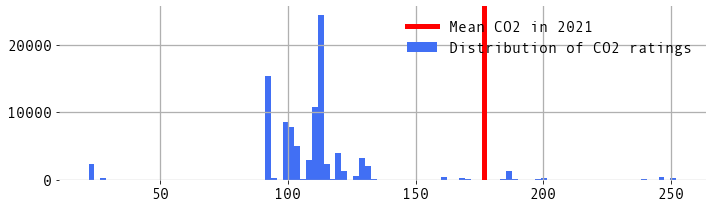

In [40]:
fig, ax = plt.subplots(figsize=(10, 3))

ax.hist(df[df.co2Emissions > 0].co2Emissions, bins=100, label='Distribution of CO2 ratings')
ax.axvline(co2_target, c='red', label='Mean CO2 in 2021')

ax.legend(loc='upper right')


plt.show()

In [41]:
# Total car sales is just the total number of vehicles in the dataframe. Each one starts with a quantifier - 1. 
total_car_sales = df.num.sum()
print("This manufacturer's total sales were {}.".format(total_car_sales))

# Now we calculate allowances under the ZEV mandate. 
allowances = (1-mandate) * total_car_sales
print("This manufacturer's total allowances were {}.".format(round(allowances)))

# Now we get the total non-ZEV sales
non_zev_sales = df[df.co2Emissions > 0].num.sum()
print("This manufacturer's total non-zev sales were {}.".format(non_zev_sales))

# Have they complied initially? The formula for compliance is as follows:
compliance = allowances - (non_zev_sales - credits)

# UK new non-ZEV sales activity - credis >= allowances
if compliance > 0:
    print("This manufacturer is ZEV Mandate compliant with a surplus of {} allowances before flexibilities.".format(round(compliance)))
    
else:
    print("This manufacturer is ZEV Mandate non-compliant with a deficit of {} allowances before flexibilities. They will need to use flexibilities.".format(round(compliance)))

This manufacturer's total sales were 95537.
This manufacturer's total allowances were 80251.
This manufacturer's total non-zev sales were 95039.
This manufacturer is ZEV Mandate non-compliant with a deficit of -14788 allowances before flexibilities. They will need to use flexibilities.


In [42]:
total_car_sales

95537

In [9]:
non_zev_sales

95039

In [10]:
# One flexibility comes from the CO2 regime. Let's see how they fare. 
activity = df.co2Emissions.sum()
co2_allowances = non_zev_sales * co2_target

if co2_allowances > activity:
    margin = co2_allowances - activity
    
    #paragraph 3.58 imposes 25% limit on transfers
    co2_zev_transfer_limit = (mandate * .25)*total_car_sales
    
    co2_zev_transfers = margin / 167
    if co2_zev_transfers < co2_zev_transfer_limit:
        pass
    else:
        co2_zev_transfers = co2_zev_transfer_limit
    
    print("This manufacturer has met their CO2 target, with {} CO2 allowances (not ZEV credits!) to spare.".format(round(margin)))
    print("This manufacturer has a spare {} ZEV credits resulting from their CO2 overperformance.".format(round(co2_zev_transfers)))
    
else:
    print("This manufacturer has a shortfall in their CO2 performance...!")

This manufacturer has met their CO2 target, with 6522561 CO2 allowances (not ZEV credits!) to spare.
This manufacturer has a spare 3821 ZEV credits resulting from their CO2 overperformance.


In [11]:
# Can they achieve compliance after any available transfers from the CO2 regime?
credits += co2_zev_transfers

# Have they complied initially? The formula for compliance is as follows:
compliance = allowances - (non_zev_sales - credits)

if compliance > 0:
    print("This manufacturer is compliant with a surplus of {} allowances before flexibilities.".format(round(compliance)))
else:
    print("This manufacturer is non-compliant with a deficit of {} allowances after taking into account the CO2 regime flexibilities.\nThey will need to use flexibilities.".format(round(compliance)))

This manufacturer is non-compliant with a deficit of -10966 allowances after taking into account the CO2 regime flexibilities.
They will need to use flexibilities.


In [12]:
# One flexibility comes from borrowing. Borrowing allows manufacturers to borrow up to 75%, 50% or 25% in the first two years of the scheme. 
# We set the cap below:

borrowing_cap = .75

borrowable_allowances = ((1-mandate) * total_car_sales) * borrowing_cap

borrowable_allowances

60188.31

In [13]:
# Can they achieve compliance after any available transfers from the borrowing flexibility?

credits += borrowable_allowances

# Have they complied initially? The formula for compliance is as follows:
compliance = allowances - (non_zev_sales - credits)

if compliance > 0:
    print("This manufacturer is compliant with a surplus of {} allowances after borrowing.".format(round(compliance)))
else:
    print("This manufacturer is non-compliant with a deficit of {} allowances before flexibilities. They will need to use flexibilities.".format(round(compliance)))

This manufacturer is compliant with a surplus of 49222 allowances after borrowing.


In [14]:
total_car_sales

95537

In [15]:
manufacturer_names = 'JLR'

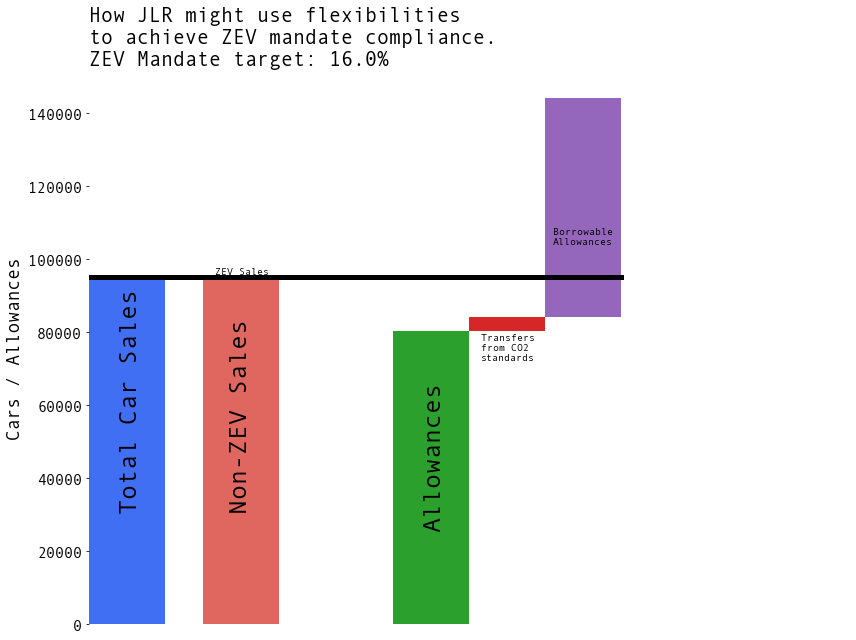

In [16]:
fig, ax = plt.subplots()

ax.set_title('How {m} might use flexibilities \nto achieve ZEV mandate compliance. \nZEV Mandate target: {t}%'.format(m=manufacturer_names, t=mandate*100), loc='left')

# ax.text(0, s='Assuming a ZEV Mandate target of {}%'.format(mandate*100), fontsize=15)
# ax.set_ylim(0, 150000)

ax.grid(False)
ax.set_xlim(0, 1)
ax.bar(.05, total_car_sales, width=0.1, label='Total Car Sales')
ax.axhline(y=non_zev_sales, xmin=0, xmax=.7, color='black', label='Required Allowances')
ax.bar(0.2, non_zev_sales, width=0.1, label='Non-ZEV Sales')
ax.bar(0.2, (total_car_sales - non_zev_sales), bottom=non_zev_sales, width=0.1, label='ZEV Sales', )
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_ylabel('Cars / Allowances')

# ax.bar(0.5, total_)
ax.bar(.45, allowances, width=0.1, label='Allowances')
ax.bar(.55, co2_zev_transfers, bottom=allowances, width=0.1, label='Credits from CO2 transfers')
ax.bar(.65, borrowable_allowances, bottom=(co2_zev_transfers + allowances), width=0.1, label='Credits from CO2 transfers', )

ax.text(.04, total_car_sales/3, s='Total Car Sales', fontsize=25, rotation='vertical')
ax.text(.185, non_zev_sales/3, s='Non-ZEV Sales', fontsize=25, rotation='vertical')
if total_car_sales > non_zev_sales:
    ax.text(.165, (non_zev_sales + (total_car_sales-non_zev_sales+2000)/3), s='ZEV Sales', fontsize=10, rotation='horizontal')
else:
    pass

ax.text(.44, allowances/3, s='Allowances', fontsize=25, rotation='vertical')
ax.text(.515, allowances - (allowances/10), s='Transfers \nfrom CO2 \nstandards', fontsize=10, rotation='horizontal')
ax.text(.61, (co2_zev_transfers + allowances+borrowable_allowances/3), s='Borrowable \nAllowances', fontsize=10, rotation='horizontal')


plt.savefig('plots/flexibilities_{}.png'.format(manufacturer_names), transparent=False, bbox_inches='tight', dpi=300)

### 2. How the allowances might change over time. 

In [17]:
# Edit the manufacturer name here for plot names later so you don't forget. Also change in SQL query below. 
man_name = 'JLR'

In [118]:
%%bigquery em_tot --project rugged-baton-283921
SELECT monthOfFirstRegistration, co2Emissions
FROM VES_dataset.VRN_UK
WHERE typeApproval = 'M1'
# AND co2Emissions >0
AND make IN ('JAGUAR', 'LAND ROVER')
AND monthOfFirstRegistration > '2020-04-01'
AND monthOfFirstRegistration < '2023-04-01'

Downloading: 100%|██████████| 169356/169356 [00:00<00:00, 225319.50rows/s]


In [119]:
em = em_tot[em_tot.co2Emissions >0]

In [120]:
c_target = em[(em.monthOfFirstRegistration.dt.year == 2021)].co2Emissions.mean()

In [121]:
c_target

176.87922671840354

In [122]:
past_average_co2 = [x[0] for x in em.groupby('monthOfFirstRegistration').mean().values.tolist()]
past_total_cars = [x[0] for x in em_tot.groupby('monthOfFirstRegistration').count().values.tolist()]
idx = em.groupby('monthOfFirstRegistration').mean().index.tolist()
idx_nodatetime = em.groupby('monthOfFirstRegistration').mean().index.map(dt.datetime.toordinal)

ndf = pd.DataFrame(data = {
    'averageCo2': past_average_co2,
    'totalCars': past_total_cars
}, index = idx)

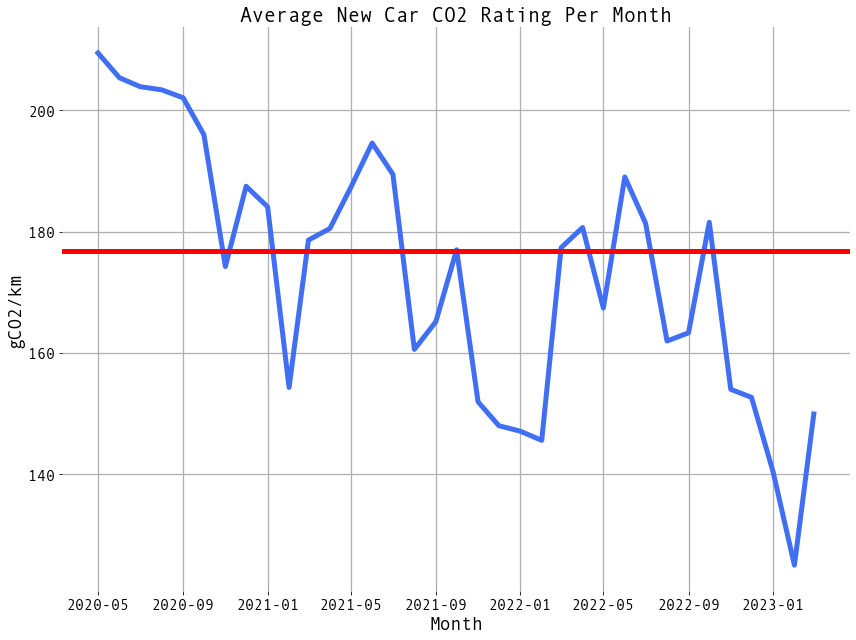

In [123]:
fig, ax = plt.subplots()

ax.plot(ndf.averageCo2)
ax.axhline(c_target, c='r', label='CO2 Performance Standard')
ax.set_ylabel('gCO2/km')
ax.set_xlabel('Month')
ax.set_title('Average New Car CO2 Rating Per Month')

plt.show()

In [124]:
y = np.array(ndf.averageCo2.values, dtype=float)
x = np.array(ndf.index.values, dtype=float)

# Simple linear regression to get the trend
slope, intercept, r_value, p_value, std_err = sp.linregress(x, y)
xf = np.linspace(min(x),max(x),100)
xf1 = xf.copy()
xf1 = pd.to_datetime(xf1)
yf = (slope*xf)+intercept
# Let's have a look at the elements of our linear regression
print('r = ', r_value, '\n', 'p = ', p_value, '\n', 's = ', std_err)

r =  -0.7238685672753309 
 p =  8.908568024788913e-07 
 s =  9.49574084785597e-17


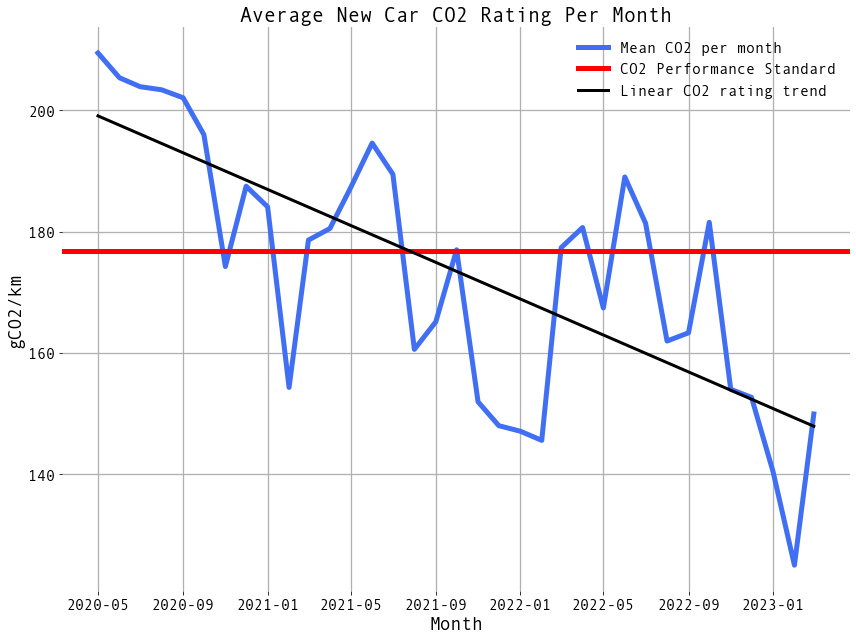

In [125]:
fig, ax = plt.subplots()

ax.plot(ndf.averageCo2, label='Mean CO2 per month')
ax.axhline(c_target, c='r', label='CO2 Performance Standard')
ax.set_ylabel('gCO2/km')
ax.set_xlabel('Month')
ax.set_title('Average New Car CO2 Rating Per Month')
ax.plot(xf1, yf, label='Linear CO2 rating trend', lw=3, c='black')
ax.legend(loc='upper right')

plt.show()

In [126]:
# Now we'll just extrapolate the trend
start = '2024-01-01'
end = '2026-12-31'
new_index = pd.date_range(start=start, end=end, freq='M')
x_f = np.array(new_index, dtype=float)

yf_f = (slope*x_f)+intercept

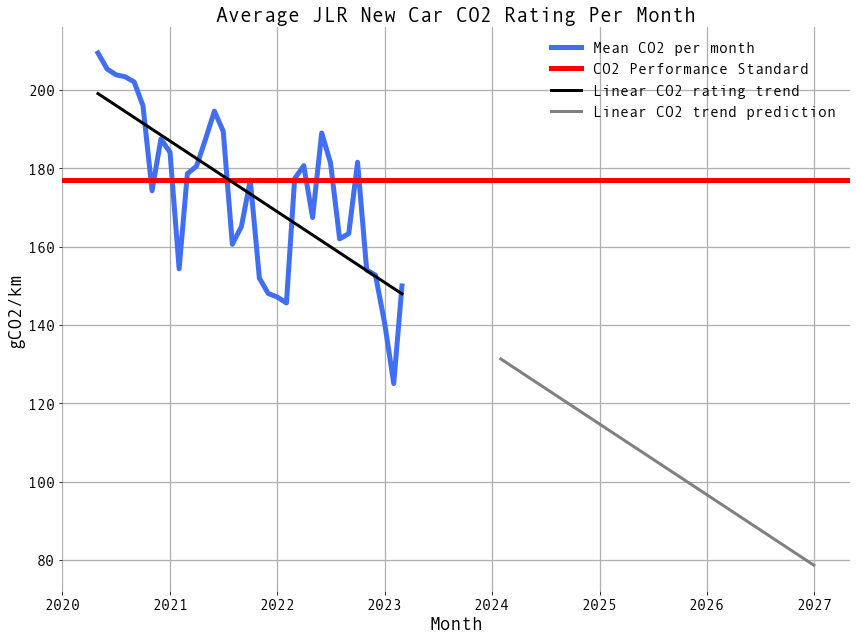

In [127]:
fig, ax = plt.subplots()

ax.plot(ndf.averageCo2, label='Mean CO2 per month')
ax.axhline(c_target, c='r', label='CO2 Performance Standard')
ax.set_ylabel('gCO2/km')
ax.set_xlabel('Month')
ax.set_title('Average {} New Car CO2 Rating Per Month'.format(man_name))
ax.plot(xf1, yf, label='Linear CO2 rating trend', lw=3, c='black')
ax.plot(new_index, yf_f, label='Linear CO2 trend prediction', lw=3, c='grey')
ax.legend(loc='upper right')

plt.show()

In [155]:
# Make a dataframe containing future values
ndf_pred = pd.DataFrame(data={
    'averageCo2': yf_f,
    'totalCars': ndf.totalCars.mean()
}, index=new_index)

ndf_pred['co2Activity'] = ndf_pred.apply(lambda row: row.averageCo2 * row.totalCars, axis=1)
ndf_pred = ndf_pred.resample('Y').agg({'averageCo2': np.mean, 'totalCars': np.sum, 'co2Activity': np.sum})
ndf_pred['co2TargetFlat'] = c_target 
# non-flat co2 target
t = c_target
c_targets = []
for e in list(range(0, 3)):
    c_targets.append(t)
    t *= .975
    
ndf_pred['co2TargetLower'] = c_targets

# CHANGE HERE TO USE THE FLAT CO2 TARGET or DESCENDING
ndf_pred['co2Allowances'] = ndf_pred.apply(lambda row: row.co2TargetFlat * row.totalCars, axis=1)
ndf_pred['compliance'] = ndf_pred.apply(lambda row: row.co2Allowances - row.co2Activity, axis=1)
# this amount is the uncapped 
ndf_pred['mandate'] = [.22, .28, .33]
ndf_pred['zevm_allowance'] = ndf_pred.apply(lambda row: (1-row.mandate)*row.totalCars, axis=1)

# The following calculation implements the cap on CO2 -> ZEVM transfers outlined in paragraph 3.58
ndf_pred['co2_zevm_credits_available'] = ndf_pred.apply(lambda row: (row.compliance / 167) if (row.compliance/167) < (row.zevm_allowance*.25) else (row.zevm_allowance)*.25, axis=1)

ndf_pred['mandate_plus_co2_flex'] = ndf_pred.apply(lambda row: 1-(row.co2_zevm_credits_available + row.zevm_allowance)/row.totalCars, axis=1)
ndf_pred['mandate_plus_co2_flex_total'] = ndf_pred.apply(lambda row: row.co2_zevm_credits_available + row.zevm_allowance, axis=1)
ndf_pred['borrowing_cap'] = [.75, .5, .25]
ndf_pred['borrowable_allowances'] = ndf_pred.apply(lambda row: row.borrowing_cap * row.zevm_allowance, axis=1)
ndf_pred['shortfall_after_allowance_co2'] = ndf_pred.apply(lambda row: row.totalCars - (row.zevm_allowance + row.co2_zevm_credits_available), axis=1)
ndf_pred['borrowed_allowances'] = ndf_pred.apply(lambda row: row.shortfall_after_allowance_co2 if row.shortfall_after_allowance_co2 < row.borrowable_allowances else row.borrowable_allowances, axis=1)

ndf_pred['bo_co2_allowance_total_mandate'] = ndf_pred.apply(lambda row: 1-(row.co2_zevm_credits_available + row.zevm_allowance + row.borrowable_allowances)/row.totalCars, axis=1)
ndf_pred['bo_co2_allowance_total'] = ndf_pred.apply(lambda row: row.co2_zevm_credits_available + row.zevm_allowance + row.borrowable_allowances, axis=1)
ndf_pred['required_zev_sales'] = ndf_pred.apply(lambda row: (row.totalCars - row.bo_co2_allowance_total) if (row.totalCars - row.bo_co2_allowance_total)>0 else 0, axis=1)


# Calculate deficit, based on 0 ZEV sales
deficit = 0

yearly_borrowing = ndf_pred['borrowed_allowances'].tolist()
accumulated_deficit = []

for i, e in enumerate(yearly_borrowing):
    deficit += e
    deficit *= 1.025
    accumulated_deficit.append(deficit)
    print(deficit)
    print(e)
    
ndf_pred['deficit'] = accumulated_deficit

1487.9134285714222
1451.622857142851
7476.764978571427
5806.491428571433
17335.12138875
9435.548571428575


In [156]:
ndf_pred

,averageCo2,totalCars,co2Activity,co2TargetFlat,co2TargetLower,co2Allowances,compliance,mandate,zevm_allowance,co2_zevm_credits_available,mandate_plus_co2_flex,mandate_plus_co2_flex_total,borrowing_cap,borrowable_allowances,shortfall_after_allowance_co2,borrowed_allowances,bo_co2_allowance_total_mandate,bo_co2_allowance_total,required_zev_sales,deficit
2024-12-31,123.070983,58064.914286,7.146106e+06,176.879227,176.879227,1.027048e+07,3.124371e+06,0.22,45290.633143,11322.658286,0.0250,56613.291429,0.75,33967.974857,1451.622857,1451.622857,-0.560,90581.266286,0,1487.913429
2025-12-31,105.018320,58064.914286,6.097880e+06,176.879227,172.457246,1.027048e+07,4.172597e+06,0.28,41806.738286,10451.684571,0.1000,52258.422857,0.50,20903.369143,5806.491429,5806.491429,-0.260,73161.792000,0,7476.764979
2026-12-31,86.969777,58064.914286,5.049893e+06,176.879227,168.145815,1.027048e+07,5.220585e+06,0.33,38903.492571,9725.873143,0.1625,48629.365714,0.25,9725.873143,9435.548571,9435.548571,-0.005,58355.238857,0,17335.121389


In [157]:
fut_idx = [pd.to_datetime('2027-12-31')]

fut_data = {key: None for key in ndf_pred.columns}

total_sales = ndf_pred.totalCars.tolist()[-1]
final_deficit = ndf_pred.deficit.tolist()[-1]

fut_data['totalCars'] = total_sales
fut_data['mandate'] = 0.38
fut_data['zevm_allowance'] = ((1-0.38)*total_sales)
fut_data['deficit'] = final_deficit * 1.025

# fut_data['']

fut_df = pd.DataFrame(
    data=fut_data,
    index=fut_idx
)

fut_df['required_zev_sales'] = fut_df.apply(lambda row: row.totalCars - (row['zevm_allowance'] - row['deficit']), axis=1)

In [158]:
pd.concat([ndf_pred, fut_df])

,averageCo2,totalCars,co2Activity,co2TargetFlat,co2TargetLower,co2Allowances,compliance,mandate,zevm_allowance,co2_zevm_credits_available,mandate_plus_co2_flex,mandate_plus_co2_flex_total,borrowing_cap,borrowable_allowances,shortfall_after_allowance_co2,borrowed_allowances,bo_co2_allowance_total_mandate,bo_co2_allowance_total,required_zev_sales,deficit
2024-12-31,123.070983,58064.914286,7.146106e+06,176.879227,176.879227,1.027048e+07,3.124371e+06,0.22,45290.633143,11322.658286,0.0250,56613.291429,0.75,33967.974857,1451.622857,1451.622857,-0.560,90581.266286,0.000000,1487.913429
2025-12-31,105.018320,58064.914286,6.097880e+06,176.879227,172.457246,1.027048e+07,4.172597e+06,0.28,41806.738286,10451.684571,0.1000,52258.422857,0.50,20903.369143,5806.491429,5806.491429,-0.260,73161.792000,0.000000,7476.764979
2026-12-31,86.969777,58064.914286,5.049893e+06,176.879227,168.145815,1.027048e+07,5.220585e+06,0.33,38903.492571,9725.873143,0.1625,48629.365714,0.25,9725.873143,9435.548571,9435.548571,-0.005,58355.238857,0.000000,17335.121389
2027-12-31,NaN,58064.914286,NaN,NaN,NaN,NaN,NaN,0.38,36000.246857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39833.166852,17768.499423


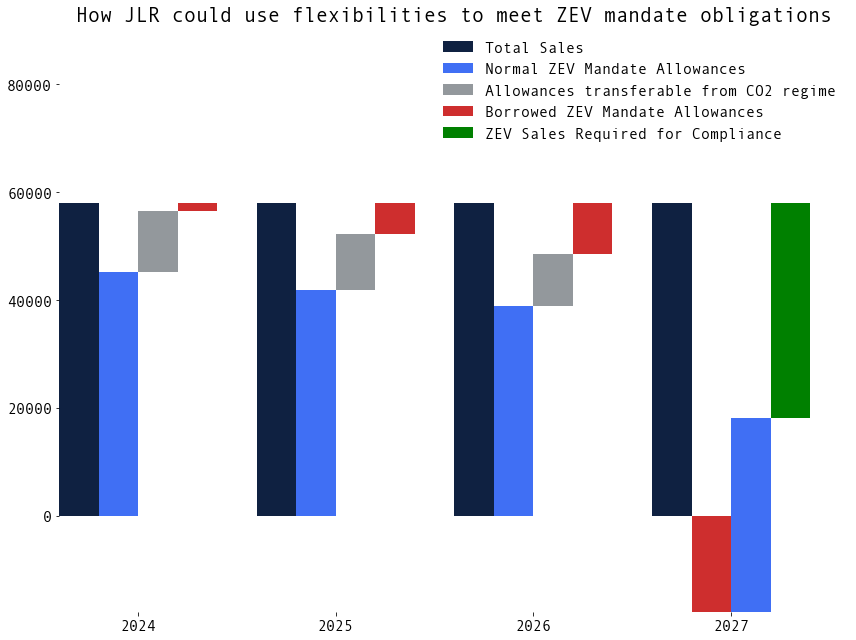

In [159]:
fig, ax = plt.subplots()
# # fig.tight_layout()
# ax[0].plot(ndf_pred.averageCo2, label='Predicted Average CO2 of Registered Cars')
# ax[0].plot(ndf_pred.co2TargetFlat, label='Flat CO2 Target')
# # ax[0].plot(ndf_pred.)

# TODO - calculate the amount that actually would be borrowed, and then create a running deficit w interest

ax.set_xlim(0, 20)
ax.grid(False)
ax.bar([.5, 5.5, 10.5, 15.5], ndf_pred.totalCars.values.tolist()[-1], width=1, label='Total Sales', color='#0F2141')
ax.bar([1.5, 6.5, 11.5], ndf_pred.zevm_allowance.values.tolist(), width=1, label='Normal ZEV Mandate Allowances', color='#406FF4')
ax.bar([2.5, 7.5, 12.5], ndf_pred.co2_zevm_credits_available.values.tolist(), bottom=ndf_pred.zevm_allowance.values.tolist(), width=1, label='Allowances transferable from CO2 regime', color='#93989C')
ax.bar([3.5, 8.5, 13.5], ndf_pred.borrowed_allowances.values.tolist(), bottom=ndf_pred.mandate_plus_co2_flex_total.values.tolist(), width=1, label='Borrowed ZEV Mandate Allowances', color='#CE2E2E')
ax.bar([4.5, 9.5, 14.5], ndf_pred.required_zev_sales.values.tolist(), bottom=ndf_pred.bo_co2_allowance_total.values.tolist(), width=1, label='ZEV Sales Required for Compliance', color='green')

# ax.bar([.5, 5.5, 15.5], ndf_pred.totalCars.values.tolist()[-1], width=1, label='Total Sales')
ax.bar(x=16.5, height=fut_df.deficit.tolist()[-1]*-1, width=1, color='#CE2E2E')
ax.bar(x=17.5, height=fut_df.zevm_allowance.tolist(), bottom=fut_df.deficit.tolist()[-1]*-1, width=1, color='#406FF4')
ax.bar(x=18.5, height=fut_df.required_zev_sales.tolist(), bottom=(fut_df.zevm_allowance.tolist()[0] + fut_df.deficit.tolist()[-1]*-1), width=1, color='green')

ax.set_xticks([2, 7, 12, 17])
ax.set_xticklabels(['2024', '2025', '2026', '2027'])
ax.set_title('How {} could use flexibilities to meet ZEV mandate obligations'.format(man_name))

ax.legend(loc='upper right')
# fig.tight_layout()
# ax[1].bar([])